In [335]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

In [336]:
train_df = pd.read_csv('train.csv')
train_df.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN


In [337]:
train_df_grouped = train_df.groupby(["image_id", "class_id"]).size().unstack(fill_value=0)

In [338]:
train_df_grouped = train_df_grouped.reset_index()
# If at least 2 columns have a value greater than 0, then the image has multiple labels
images = train_df_grouped[(train_df_grouped.iloc[:, 1:] > 0).sum(axis=1) > 1]

In [339]:
images

class_id,image_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
2,0005e8e3701dfb1dd93d53e2ff537b6e,0,0,0,0,1,0,1,2,1,0,0,0,0,0,0
4,0007d316f756b3fa0baea2ff514ce945,2,0,0,1,0,2,0,0,0,0,0,3,0,3,0
6,000d68e42b71d3eac10ccc077aba07c1,1,0,0,0,0,0,0,2,0,10,0,2,0,1,0
7,00150343289f317a0ad5629d5b7d9ef9,3,0,0,1,0,0,0,2,0,1,4,4,0,2,0
9,001d127bad87592efe45a5c7678f8b8d,0,0,1,0,0,0,0,0,0,0,0,0,0,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14977,ff6b2b10b8f2350ab09d8690c9c83154,3,0,0,1,0,0,0,0,0,0,0,0,0,0,0
14986,ff924bcbd38f123aec723aa7040d7e43,0,2,0,0,2,0,0,1,0,0,6,6,0,6,0
14987,ffb5d0b005261ed350f7a08c06613a34,3,0,0,3,0,0,0,0,0,0,0,0,0,0,0
14991,ffceb71a80efba3b83c88e11f4b9694b,0,0,0,3,0,0,0,0,0,0,0,0,0,2,0


In [340]:
# Print images where class_id 14 is present
images[images[3] > 0]

class_id,image_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
4,0007d316f756b3fa0baea2ff514ce945,2,0,0,1,0,2,0,0,0,0,0,3,0,3,0
7,00150343289f317a0ad5629d5b7d9ef9,3,0,0,1,0,0,0,2,0,1,4,4,0,2,0
23,00675cd546313f912cadd4ad54415d69,3,0,0,3,0,0,0,0,0,0,0,0,0,0,0
30,008b3176a7248a0a189b5731ac8d2e95,0,0,0,1,0,0,0,3,6,2,0,0,0,0,0
39,00aca42a24e4ea6066cca2546150c36e,3,0,0,1,0,0,0,2,0,0,1,2,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14970,ff4cd09578f32d803e5996a4a2ec29b2,0,0,0,3,0,0,0,1,0,2,0,0,0,0,0
14977,ff6b2b10b8f2350ab09d8690c9c83154,3,0,0,1,0,0,0,0,0,0,0,0,0,0,0
14987,ffb5d0b005261ed350f7a08c06613a34,3,0,0,3,0,0,0,0,0,0,0,0,0,0,0
14991,ffceb71a80efba3b83c88e11f4b9694b,0,0,0,3,0,0,0,0,0,0,0,0,0,2,0


In [341]:
images[images[14] > 0]

class_id,image_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14


In [342]:
# Count nb of unique images 
print("Number of unique images with multiple labels: ", images.image_id.nunique())

Number of unique images with multiple labels:  4065


In [343]:
data_dicom = pd.read_csv('/Volumes/ALEXIS/ai_project_cranfield/dicom_metadata.csv')
data_dicom.head()

,File Name,Transfer Syntax UID,SOP Class UID,SOP Instance UID,Version,Photometric Interpretation,Pixel Representation,High Bit,Samples per Pixel,Bits Allocated,...,Lossy Image Compression,Lossy Image Compression Ratio,Patient's Sex,Patient's Age,Rows,Columns,Pixel Spacing,Bits Stored,Window Center,Window Width
0,f7f7736401b22c94a9d2b09425adeab9.dicom,1.2.840.10008.1.2.4.90,1.2.840.10008.5.1.4.1.1.1.1,f7f7736401b22c94a9d2b09425adeab9,INF_3.9,MONOCHROME2,0,11,1,16,...,0.0,NaN,F,037Y,3028,2517,"[0.139, 0.139]",12,2048.0,4096.0
1,93ae57ca1df1d19c6d64155e74e14d23.dicom,1.2.840.10008.1.2,1.2.840.10008.5.1.4.1.1.1.1,93ae57ca1df1d19c6d64155e74e14d23,NaN,MONOCHROME2,0,13,1,16,...,NaN,NaN,O,Y,3072,3072,"[0.139000, 0.139000]",14,10287.0,5292.0
2,f1a45afaee0efd07fef17057f3942464.dicom,1.2.840.10008.1.2.4.90,1.2.840.10008.5.1.4.1.1.1,f1a45afaee0efd07fef17057f3942464,OFFIS_DCMTK_360,MONOCHROME1,0,11,1,16,...,0.0,NaN,M,NaN,2880,2304,"[0.15, 0.15]",12,2047.0,4095.0
3,559fdfb3b9db3eb206b9521824f716e3.dicom,1.2.840.10008.1.2,1.2.840.10008.5.1.4.1.1.1,559fdfb3b9db3eb206b9521824f716e3,OFFIS_DCMTK_360,MONOCHROME2,0,13,1,16,...,NaN,NaN,M,038Y,3072,2540,"[0.140, 0.140]",14,10075.0,10242.0
4,371d6f540ac601affe81e547b05c551a.dicom,1.2.840.10008.1.2,1.2.840.10008.5.1.4.1.1.1,371d6f540ac601affe81e547b05c551a,OFFIS_DCMTK_360,MONOCHROME2,0,13,1,16,...,NaN,NaN,M,060Y,3072,3072,"[0.140, 0.140]",14,8755.0,10228.0


In [344]:
data_dicom.shape

(15000, 22)

In [345]:
data_dicom.columns

Index(['File Name', 'Transfer Syntax UID', 'SOP Class UID', 'SOP Instance UID',
       'Version', 'Photometric Interpretation', 'Pixel Representation',
       'High Bit', 'Samples per Pixel', 'Bits Allocated', 'Rescale Intercept',
       'Rescale Slope', 'Lossy Image Compression',
       'Lossy Image Compression Ratio', 'Patient's Sex', 'Patient's Age',
       'Rows', 'Columns', 'Pixel Spacing', 'Bits Stored', 'Window Center',
       'Window Width'],
      dtype='object')

In [346]:
data_dicom = data_dicom.rename(columns={"SOP Instance UID": "image_id"})
data_dicom = data_dicom[
    [
        "image_id",
        "Transfer Syntax UID",
        "SOP Class UID",
        "Version",
        "Photometric Interpretation",
        "Pixel Representation",
        "High Bit",
        "Samples per Pixel",
        "Bits Allocated",
        "Rescale Intercept",
        "Rescale Slope",
        "Lossy Image Compression",
        "Lossy Image Compression Ratio",
        "Patient's Sex",
        "Patient's Age",
        "Rows",
        "Columns",
        "Pixel Spacing",
        "Bits Stored",
        "Window Center",
        "Window Width",
    ]
]

In [347]:
data_dicom["image_id"] = data_dicom["image_id"].str.replace(".dicom", "")
data_dicom

,image_id,Transfer Syntax UID,SOP Class UID,Version,Photometric Interpretation,Pixel Representation,High Bit,Samples per Pixel,Bits Allocated,Rescale Intercept,...,Lossy Image Compression,Lossy Image Compression Ratio,Patient's Sex,Patient's Age,Rows,Columns,Pixel Spacing,Bits Stored,Window Center,Window Width
0,f7f7736401b22c94a9d2b09425adeab9,1.2.840.10008.1.2.4.90,1.2.840.10008.5.1.4.1.1.1.1,INF_3.9,MONOCHROME2,0,11,1,16,0.0,...,0.0,NaN,F,037Y,3028,2517,"[0.139, 0.139]",12,2048.0,4096.0
1,93ae57ca1df1d19c6d64155e74e14d23,1.2.840.10008.1.2,1.2.840.10008.5.1.4.1.1.1.1,NaN,MONOCHROME2,0,13,1,16,0.0,...,NaN,NaN,O,Y,3072,3072,"[0.139000, 0.139000]",14,10287.0,5292.0
2,f1a45afaee0efd07fef17057f3942464,1.2.840.10008.1.2.4.90,1.2.840.10008.5.1.4.1.1.1,OFFIS_DCMTK_360,MONOCHROME1,0,11,1,16,0.0,...,0.0,NaN,M,NaN,2880,2304,"[0.15, 0.15]",12,2047.0,4095.0
3,559fdfb3b9db3eb206b9521824f716e3,1.2.840.10008.1.2,1.2.840.10008.5.1.4.1.1.1,OFFIS_DCMTK_360,MONOCHROME2,0,13,1,16,0.0,...,NaN,NaN,M,038Y,3072,2540,"[0.140, 0.140]",14,10075.0,10242.0
4,371d6f540ac601affe81e547b05c551a,1.2.840.10008.1.2,1.2.840.10008.5.1.4.1.1.1,OFFIS_DCMTK_360,MONOCHROME2,0,13,1,16,0.0,...,NaN,NaN,M,060Y,3072,3072,"[0.140, 0.140]",14,8755.0,10228.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,0c5ff01c7bfb4362fcd98f36e555b08c,1.2.840.10008.1.2.4.90,1.2.840.10008.5.1.4.1.1.1,OFFIS_DCMTK_360,MONOCHROME1,0,11,1,16,0.0,...,0.0,NaN,F,NaN,2880,2304,"[0.15, 0.15]",12,2047.0,4095.0
14996,3286115baacb6ed3affc5c46c9205b7a,1.2.840.10008.1.2,1.2.840.10008.5.1.4.1.1.1,OFFIS_DCMTK_360,MONOCHROME1,0,11,1,16,0.0,...,0.0,NaN,F,NaN,2880,2304,"[0.15, 0.15]",12,2047.0,4095.0
14997,d44766bf0eb902fbc1848f418417c45f,1.2.840.10008.1.2.4.90,1.2.840.10008.5.1.4.1.1.1,OFFIS_DCMTK_360,MONOCHROME1,0,11,1,16,0.0,...,NaN,NaN,F,035Y,2208,2104,NaN,12,NaN,NaN
14998,cd7b83d24ee9c092a0f32cb020da6dac,1.2.840.10008.1.2,1.2.840.10008.5.1.4.1.1.1.1,NaN,MONOCHROME2,0,11,1,16,0.0,...,0.0,NaN,NaN,NaN,2926,2847,"[0.125, 0.125]",12,1202.0,5482.0


In [348]:
df_merged = pd.merge(train_df, data_dicom, on='image_id')
df_merged.columns

Index(['image_id', 'class_name', 'class_id', 'rad_id', 'x_min', 'y_min',
       'x_max', 'y_max', 'Transfer Syntax UID', 'SOP Class UID', 'Version',
       'Photometric Interpretation', 'Pixel Representation', 'High Bit',
       'Samples per Pixel', 'Bits Allocated', 'Rescale Intercept',
       'Rescale Slope', 'Lossy Image Compression',
       'Lossy Image Compression Ratio', 'Patient's Sex', 'Patient's Age',
       'Rows', 'Columns', 'Pixel Spacing', 'Bits Stored', 'Window Center',
       'Window Width'],
      dtype='object')

In [349]:
df_merged.shape

(67914, 28)

In [350]:
Photometric_Interpretation = df_merged['Photometric Interpretation'].unique()
Photometric_Interpretation

array(['MONOCHROME2', 'MONOCHROME1'], dtype=object)

In [351]:
Photometric_Interpretation_class = {"MONOCHROME2": 2, "MONOCHROME1": 1}
df_merged["Photometric_Interpretation_class"] = df_merged["Photometric Interpretation"].map(
    Photometric_Interpretation_class
)

In [352]:
Transfer_Syntax_UID = df_merged["Transfer Syntax UID"].unique()
Transfer_Syntax_UID

array(['1.2.840.10008.1.2.4.90', '1.2.840.10008.1.2',
       '1.2.840.10008.1.2.1'], dtype=object)

In [353]:
Transfer_Syntax_UID_class = {
    "1.2.840.10008.1.2.4.90": 1,
    "1.2.840.10008.1.2": 2,
    "1.2.840.10008.1.2.1": 3,
}
df_merged["Transfer_Syntax_UID_class"] = df_merged["Transfer Syntax UID"].map(Transfer_Syntax_UID_class)

In [354]:
SOP_Class_UID = df_merged['SOP Class UID'].unique()
SOP_Class_UID

array(['1.2.840.10008.5.1.4.1.1.1', '1.2.840.10008.5.1.4.1.1.1.1'],
      dtype=object)

In [355]:
SOP_Class_UID = {
    "1.2.840.10008.5.1.4.1.1.1": 1,
    "1.2.840.10008.5.1.4.1.1.1.1": 2,
}
df_merged["SOP_Class_UID"] = df_merged["SOP Class UID"].map(SOP_Class_UID)

In [356]:
Version = df_merged['Version'].unique()
Version

array(['INF_3.9', nan, 'OFFIS_DCMTK_360', 'dcm4che-1.4.34', 'INF_4.5'],
      dtype=object)

In [357]:
versions_class = {"INF_3.9": 1, "OFFIS_DCMTK_360": 2, "dcm4che-1.4.34": 3, "INF_4.5": 4, np.nan: 0}
df_merged["Version_class"] = df_merged["Version"].map(versions_class)

In [358]:
sex = df_merged["Patient's Sex"].unique()
sex

array(['M', nan, 'F', 'O'], dtype=object)

In [359]:
sex_class = {"M": 1, "F": 2, "O": 3, np.nan: 0}
df_merged["sex_class"] = df_merged["Patient's Sex"].map(sex_class)

In [360]:
age = df_merged["Patient's Age"].unique()
age

array([nan, '061Y', '022Y', '119Y', '000Y', '055Y', '056Y', '062Y',
       '039Y', 'Y', '071Y', '068Y', '083Y', '077Y', '057Y', '060Y',
       '070Y', '081Y', '059Y', '079Y', '074Y', '000D', '045Y', '064Y',
       '069Y', '037Y', '032Y', '058Y', '052Y', '013Y', '067Y', '027Y',
       '016Y', '033Y', '065Y', '026Y', '078Y', '008Y', '085Y', '053Y',
       '050Y', '047Y', '051Y', '048Y', '080Y', '043Y', '076Y', '036Y',
       '093Y', '063Y', '034Y', '073Y', '040Y', '072Y', '044Y', '041Y',
       '042Y', '066Y', '090Y', '092Y', '054Y', '046Y', '049Y', '011Y',
       '023Y', '035Y', '038Y', '030Y', '075Y', '086Y', '028Y', '024Y',
       '088Y', '017Y', '029Y', '087Y', '031Y', '019Y', '094Y', '025Y',
       '084Y', '012Y', '089Y', '082Y', '238Y', '020Y', '009Y', '021Y',
       '095Y', '002Y', '006Y', '018Y', '015Y', '007Y', '098Y', '091Y',
       '118Y', '014Y', '010Y', '003Y', '124Y', '097Y', '005Y', '004Y'],
      dtype=object)

In [361]:
age_class = {np.nan: 0}
for i in range(1, len(age)):
    age_class[age[i]] = i
df_merged["age_class"] = df_merged["Patient's Age"].map(age_class)

<Axes: >

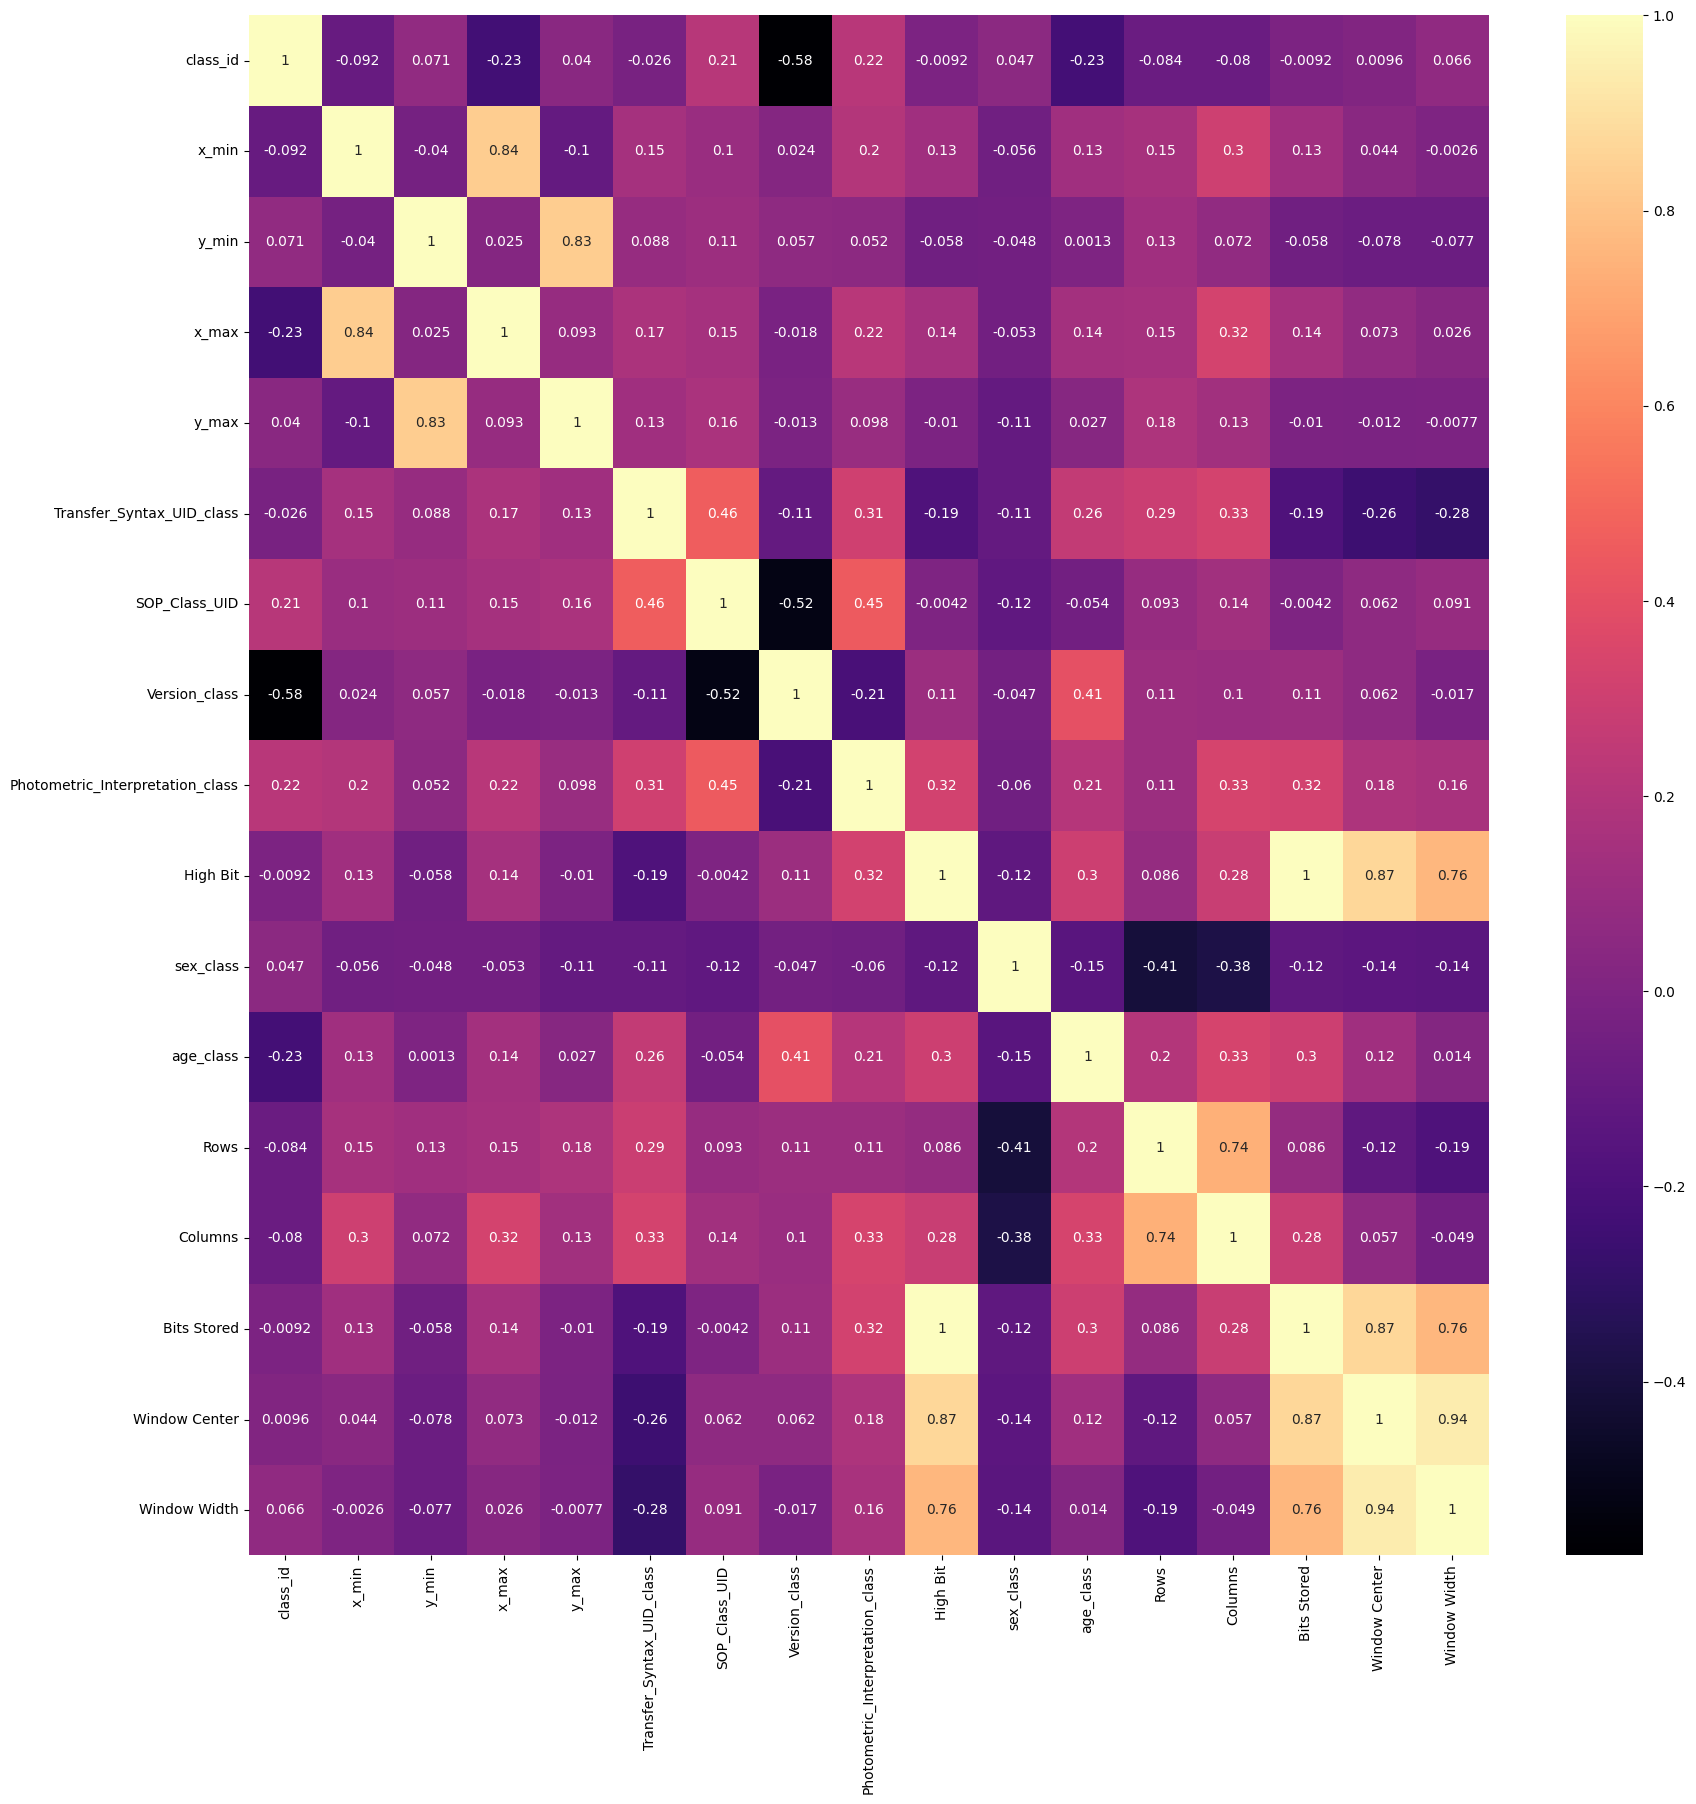

In [362]:
corr = df_merged[
    [
        "class_id",
        "rad_id",
        "x_min",
        "y_min",
        "x_max",
        "y_max",
        "Transfer_Syntax_UID_class",
        "SOP_Class_UID",
        "Version_class",
        "Photometric_Interpretation_class",
        "High Bit",
        "sex_class",
        "age_class",
        "Rows",
        "Columns",
        "Pixel Spacing",
        "Bits Stored",
        "Window Center",
        "Window Width",
    ]
].corr(numeric_only=True)

plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=True, cmap="magma")


In [363]:
df_merged.columns

Index(['image_id', 'class_name', 'class_id', 'rad_id', 'x_min', 'y_min',
       'x_max', 'y_max', 'Transfer Syntax UID', 'SOP Class UID', 'Version',
       'Photometric Interpretation', 'Pixel Representation', 'High Bit',
       'Samples per Pixel', 'Bits Allocated', 'Rescale Intercept',
       'Rescale Slope', 'Lossy Image Compression',
       'Lossy Image Compression Ratio', 'Patient's Sex', 'Patient's Age',
       'Rows', 'Columns', 'Pixel Spacing', 'Bits Stored', 'Window Center',
       'Window Width', 'Photometric_Interpretation_class',
       'Transfer_Syntax_UID_class', 'SOP_Class_UID', 'Version_class',
       'sex_class', 'age_class'],
      dtype='object')

In [364]:
train_df.shape

(67914, 8)

In [365]:
train_df["class_id"].unique()

array([14,  3,  0, 11,  5,  8, 13,  7,  1,  9,  6, 10,  2,  4, 12])

In [366]:
train_df["class_name"].unique()

array(['No finding', 'Cardiomegaly', 'Aortic enlargement',
       'Pleural thickening', 'ILD', 'Nodule/Mass', 'Pulmonary fibrosis',
       'Lung Opacity', 'Atelectasis', 'Other lesion', 'Infiltration',
       'Pleural effusion', 'Calcification', 'Consolidation',
       'Pneumothorax'], dtype=object)

In [367]:
train_df['image_id'].unique().shape

(15000,)

In [368]:
# Count number of classes for each image
image_class_count = train_df.groupby('image_id').size().reset_index(name='class_count')
image_class_count.head()

,image_id,class_count
0,000434271f63a053c4128a0ba6352c7f,3
1,00053190460d56c53cc3e57321387478,3
2,0005e8e3701dfb1dd93d53e2ff537b6e,5
3,0006e0a85696f6bb578e84fafa9a5607,3
4,0007d316f756b3fa0baea2ff514ce945,11


In [369]:

# Assuming df is your DataFrame loaded from the CSV
# Update this path to the directory where your DICOM files are stored
dicom_files_directory = '/Volumes/ALEXIS/ai_project_cranfield/train/'

def load_dicom(path):
    dicom = pydicom.dcmread(path)
    # Apply VOI LUT if available
    image = apply_voi_lut(dicom.pixel_array, dicom)
    # Normalize the image
    if dicom.PhotometricInterpretation == "MONOCHROME1":
        image = np.amax(image) - image
    image = image - np.min(image)
    image = image / np.max(image)
    image = (image * 255).astype(np.uint8)
    return image

In [370]:
test_image = pydicom.dcmread(os.path.join(dicom_files_directory, train_df.iloc[40]['image_id'] + '.DICOM'))
print(test_image)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 156
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Digital X-Ray Image Storage - For Presentation
(0002, 0003) Media Storage SOP Instance UID      UI: 8e063eadea9a6aeb684c893c8598be3e
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.3.4
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0010, 0040) Patient's Sex                       CS: 'M'
(0010, 1010) Patient's Age                       AS: '061Y'
(0028, 0002) Samples per Pixel                   US: 1
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROME2'
(0028, 0010) Rows                                US: 3180
(0028, 0011) Columns                             US: 2836
(0028, 0030) Pixel Spacing

## Pixel Array Features Extraction

In [371]:
import logging
import h5py

logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)

def get_pixel_array_from_hdf5(hdf5_path, filename):
    """
    Retrieves the pixel array for a given filename from an HDF5 file.

    Parameters:
    - hdf5_path: Path to the HDF5 file.
    - filename: The original file name of the DICOM image.

    Returns:
    - A numpy array of the pixel data if found; None otherwise.
    """
    with h5py.File(hdf5_path, "r") as hdf5_file:
        # Attempt to access the dataset directly by filename.
        # Adjust this part if a more complex naming convention is used.
        unique_filename = None
        for key in hdf5_file.keys():
            if filename in key:
                unique_filename = key
                break
                
        if unique_filename is not None:
            pixel_array = hdf5_file[unique_filename][:]
            return pixel_array
        else:
            logging.error(f"File {filename} not found in HDF5.")
            return None

In [372]:
with h5py.File("/Volumes/ALEXIS/ai_project_cranfield/dicom_images_final.hdf5", "r") as hdf5_file:
    # Count the number of datasets (keys) directly
    num_datasets = len(hdf5_file.keys())

# Print the number of datasets
print(num_datasets)

15000


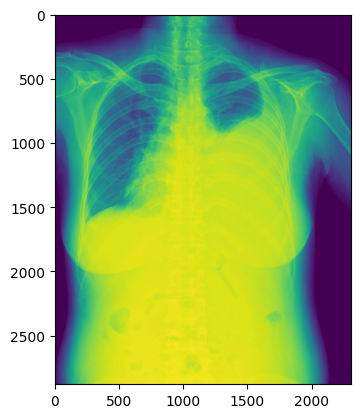

In [373]:
filename = "0a0ac65c40a9ac441651e4bfbde03c4e.dicom"  # This should be the base name of the file you're looking for.
pixel_array = get_pixel_array_from_hdf5("/Volumes/ALEXIS/ai_project_cranfield/dicom_images_final.hdf5", filename)
plt.imshow(pixel_array)

In [374]:
from PIL import Image
image = Image.fromarray(pixel_array).convert("RGB")
np.shape(image)[:2]

(2880, 2304)

## Intensity Features Extraction

In [375]:
def extract_intensity_features(image):
    """
    Extracts intensity features from a given image.

    Parameters:
    - image: A 2D numpy array representing the image.

    Returns:
    - A dictionary containing the extracted features.
    """
    features = {}
    features["mean_intensity"] = np.mean(image)  # Mean intensity
    features["std_intensity"] = np.std(image)  # Standard deviation of intensity
    features["hist_intensity"], bin_edges = np.histogram(
        image.ravel(), bins=256, range=(0, 256), density=True
    )  # Intensity histogram
    return features

Mean Intensity: 155.5293157130112
Standard Deviation of Intensity: 87.50415111316013


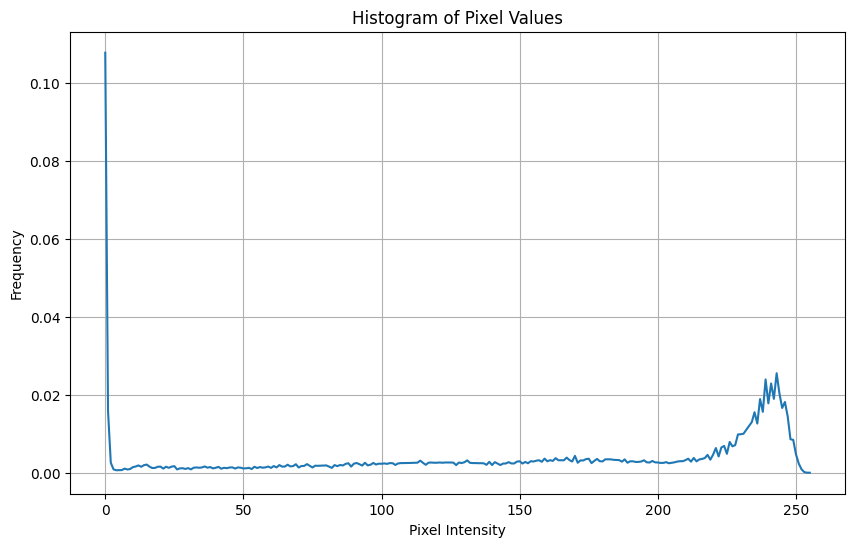

In [376]:
def plot_histogram(histogram, bin_edges):
    """
    Plot the histogram of pixel values.

    Parameters:
    - histogram: The values of the histogram.
    - bin_edges: The bin edges corresponding to the histogram.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(
        bin_edges[0:-1], histogram
    )  # bin_edges is one element longer than histogram
    plt.title("Histogram of Pixel Values")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()


intensity_features = extract_intensity_features(pixel_array) # Extract intensity features
print(f"Mean Intensity: {intensity_features['mean_intensity']}") # Print mean intensity
print(f"Standard Deviation of Intensity: {intensity_features['std_intensity']}") # Print standard deviation of intensity
plot_histogram(intensity_features["hist_intensity"], np.arange(257)) # Plot histogram

In [377]:
intensity_features["hist_intensity"].shape

(256,)

## Texture Features Extraction

### Gray-Level Co-occurrence Matrix (GLCM) Features

In [378]:
from skimage.feature import graycomatrix, graycoprops
import numpy as np


def calculate_glcm_features(image, distances, angles):
    """
    Calculate GLCM properties like contrast, correlation, energy, and homogeneity.

    Parameters:
    - image: 2D numpy array, preprocessed image.
    - distances: List of pixel distances for GLCM calculation.
    - angles: List of angles (in radians) for GLCM calculation.

    Returns:
    - Dictionary of GLCM features.
    """
    glcm = graycomatrix(
        image,
        distances=distances,
        angles=angles,
        levels=256,
        symmetric=True,
        normed=True,
    )
    features = {
        "contrast": graycoprops(glcm, "contrast").mean(),
        "correlation": graycoprops(glcm, "correlation").mean(),
        "energy": graycoprops(glcm, "energy").mean(),
        "homogeneity": graycoprops(glcm, "homogeneity").mean(),
    }
    return features

### Local Binary Pattern (LBP) Features

In [379]:
from skimage.feature import local_binary_pattern

def extract_lbp_features(image, P=8, R=1, method='uniform', visualize=False):
    """
    Extract Local Binary Pattern (LBP) features.
    Parameters:
    - image: 2D numpy array, preprocessed image.
    - P: Number of circularly symmetric neighbor set points.
    - R: Radius of circle.
    - method: Method for computing LBP.
    Returns:
    - LBP image.
    """
    lbp_image = local_binary_pattern(image, P, R, method)
    lbp_hist, _ = np.histogram(lbp_image.ravel(), bins=np.arange(0, P + 3), range=(0, P + 2))
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= (lbp_hist.sum() + 1e-6)  # Normalize

    
    if visualize:
        plt.figure(figsize=(8, 4))
        plt.bar(np.arange(0, P + 2), lbp_hist, width=0.8, align="center")
        plt.title('LBP Histogram')
        plt.xlabel('LBP Value')
        plt.ylabel('Frequency')
        plt.show()

    return lbp_hist

### Gabor Filters

In [380]:
from skimage.filters import gabor

def calculate_gabor_features(image, frequency, theta, visualize=False):
    """
    Apply Gabor filters to extract texture features.
    
    Parameters:
    - image: 2D numpy array, preprocessed image.
    - frequency: Spatial frequency of the sinusoidal factor.
    - theta: Orientation of the normal to the parallel stripes of a Gabor function.
    
    Returns:
    - Gabor filtered image.
    """
    gabor_response_real, gabor_response_imag = gabor(image, frequency=frequency, theta=theta)

    if visualize:
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.title("Gabor Filtered Image (Real)")
        plt.imshow(gabor_response_real, cmap="gray")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.title("Gabor Filtered Image (Imaginary)")
        plt.imshow(gabor_response_imag, cmap="gray")
        plt.axis("off")

        plt.show()


    return gabor_response_real, gabor_response_imag


### Haralick Features

In [381]:
import mahotas as mh
from pylab import imshow

def extract_haralick_features(image, sigma=5, visualize=False): 
    """
    Extract Haralick texture features using mahotas.
    Parameters:
    - image: 2D numpy array, preprocessed image.
    Returns:
    - Haralick features.
    """
    # setting gaussian filter
    gaussian = mh.gaussian_filter(image, sigma)

    # setting threshold value
    gaussian = (gaussian > gaussian.mean())

    # making is labelled image
    labeled, n = mh.label(gaussian)

    # computing haralick features
    h_feature = mh.features.haralick(labeled)

    # Visualize the Haralick features
    if visualize:
        plt.figure(figsize=(10, 5))
        plt.title("Labeled Image")
        imshow(labeled)
        plt.show()

        plt.figure(figsize=(12, 6))
        plt.title("Haralick Features")
        imshow(h_feature)
        
    return h_feature


### Test

GLCM Features: {'contrast': 12.400590413470354, 'correlation': 0.9991897232819489, 'energy': 0.10773901730783368, 'homogeneity': 0.3792180458373555}


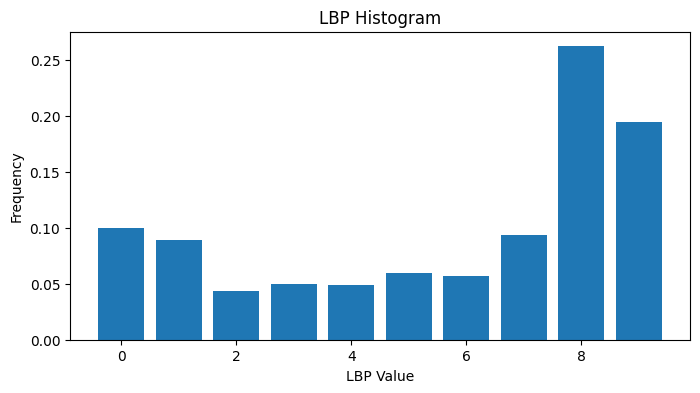

LBP Image: (10,)


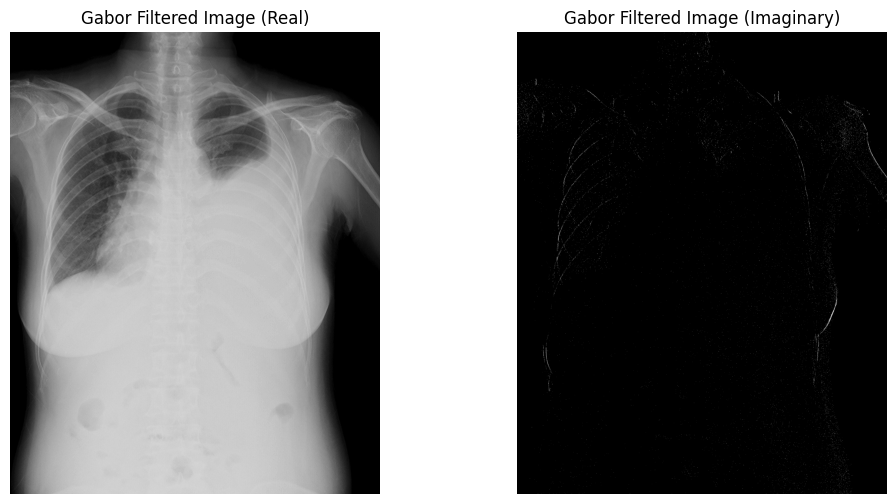

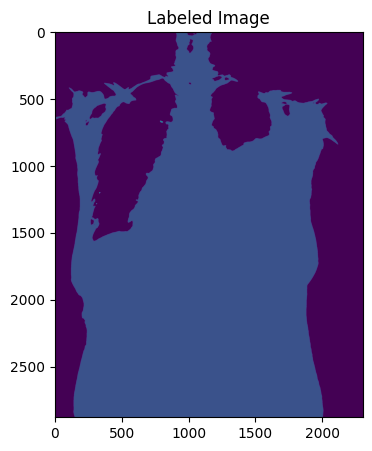

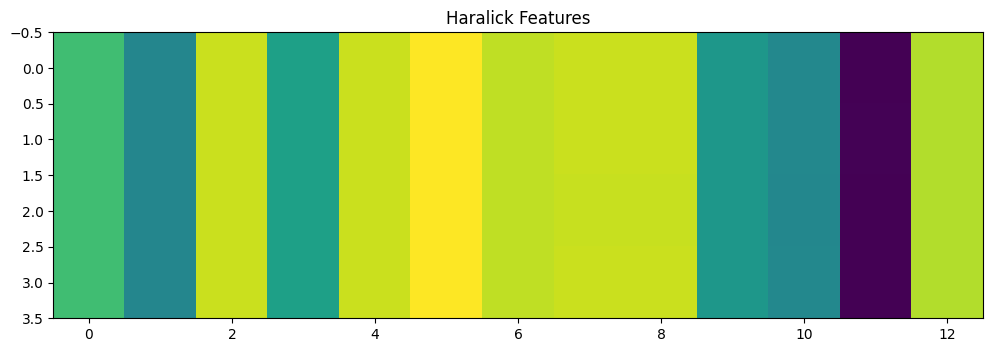

In [382]:
glcm_features = calculate_glcm_features(pixel_array, distances=[1], angles=[0])
print("GLCM Features:", glcm_features)


lbp_image = extract_lbp_features(
    pixel_array, P=8, R=1, method="uniform", visualize=True
)
print("LBP Image:", lbp_image.shape)

gabor_response_real, gabor_response_imag = calculate_gabor_features(
    pixel_array, frequency=0.6, theta=0, visualize=True
)

haralick_features = extract_haralick_features(pixel_array, sigma=5, visualize=True)

In [383]:
haralick_features.shape

(4, 13)

##  Edge Detection Features Extraction

### Sobel Operator

In [384]:
from skimage.filters import sobel


def apply_sobel_operator(image, visualize=False):
    """
    Apply the Sobel operator to highlight edges in the image.

    Parameters:
    - image: 2D numpy array, preprocessed image.

    Returns:
    - Sobel filtered image.
    """
    sobel_edges = sobel(image)

    if visualize:
        plt.figure(figsize=(8, 4))
        plt.title("Sobel Filtered Image")
        plt.imshow(sobel_edges, cmap="gray")
        plt.axis("off")
        plt.show()

    return sobel_edges

### Canny Edge Detector

In [385]:
from skimage.feature import canny


def apply_canny_edge_detector(image, sigma=1, visualize=False):
    """
    Use the Canny edge detector for identifying edges with more accuracy.

    Parameters:
    - image: 2D numpy array, preprocessed image.
    - sigma: Standard deviation of the Gaussian filter used in Canny edge detector.

    Returns:
    - Canny edge detected image.
    """
    canny_edges = canny(image, sigma=sigma)

    if visualize:
        plt.figure(figsize=(8, 4))
        plt.title("Canny Edge Detected Image")
        plt.imshow(canny_edges, cmap="gray")
        plt.axis("off")
        plt.show()

    return canny_edges

### Test

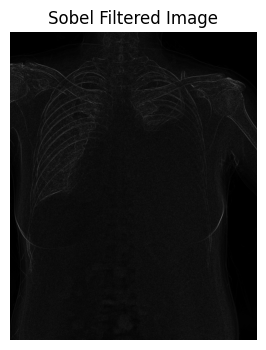

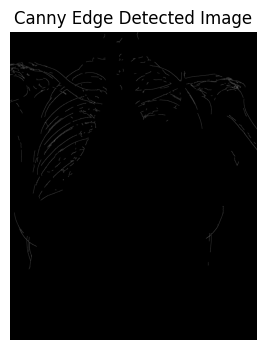

In [386]:
sobel_edges = apply_sobel_operator(pixel_array, visualize=True)
canny_edges = apply_canny_edge_detector(pixel_array, sigma=1, visualize=True)

## Shape Features Extraction

### Histogram of Oriented Gradients (HOG)

In [387]:
from skimage.feature import hog
from skimage import exposure


def calculate_hog_features(
    image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False
):
    """
    Calculate HOG features to outline the presence of specific shapes or orientations.

    Parameters:
    - image: 2D numpy array, preprocessed image.
    - pixels_per_cell: Size (in pixels) of a cell.
    - cells_per_block: Number of cells in each block.
    - visualize: If True, return an image of the HOG.

    Returns:
    - HOG features, and optionally the HOG image.
    """
    fd, hog_image = hog(
        image,
        pixels_per_cell=pixels_per_cell,
        cells_per_block=cells_per_block,
        visualize=visualize,
        feature_vector=True,
    )
    if visualize:
        hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
        
        plt.figure(figsize=(8, 4))
        plt.title("HOG Image")
        plt.imshow(hog_image_rescaled, cmap="gray")
        plt.axis("off")
        plt.show()
    
    return fd, hog_image

### Test

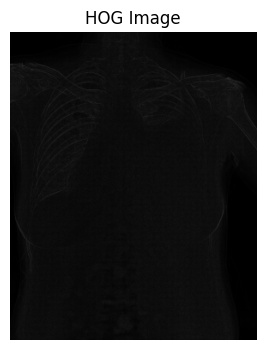

In [388]:
# Calculate HOG features
hog_features, hog_image = calculate_hog_features(pixel_array, visualize=True)


## Statistical Feature Extraction 

In [389]:
import numpy as np
from scipy.stats import skew, kurtosis
from scipy import ndimage

def calculate_statistical_features(image):
    """
    Calculate statistical features: skewness, kurtosis, and entropy.
    
    Parameters:
    - image: 2D numpy array, preprocessed image.
    
    Returns:
    - A dictionary containing the calculated features.
    """
    # Flatten the image to 1D for statistical analysis
    flattened_image = image.flatten()
    
    # Calculate skewness
    image_skewness = skew(flattened_image)
    
    # Calculate kurtosis
    image_kurtosis = kurtosis(flattened_image)
    
    # Calculate entropy
    histogram, _ = np.histogram(flattened_image, bins=256, range=(0, 255))
    histogram_normalized = histogram / histogram.sum()
    entropy = -np.sum(histogram_normalized * np.log2(histogram_normalized + np.finfo(float).eps))  # Add epsilon to avoid log(0)
    
    return {
        'skewness': image_skewness,
        'kurtosis': image_kurtosis,
        'entropy': entropy
    }


In [390]:
# Assuming `image` is your preprocessed image
# Example usage:

statistical_features = calculate_statistical_features(pixel_array)

print(f"Skewness: {statistical_features['skewness']}")
print(f"Kurtosis: {statistical_features['kurtosis']}")
print(f"Entropy: {statistical_features['entropy']}")

Skewness: -0.6349764872123987
Kurtosis: -1.0466161810474348
Entropy: 7.098414976311307


## Frequency Domain Features Extraction

### Wavelet Transform Features 

In [391]:
import pywt

def extract_wavelet_features(image, mode='haar', level=1, visualize=False):
    """
    Extract Wavelet Transform features.
    Parameters:
    - image: 2D numpy array, preprocessed image.
    - mode: Type of wavelet to use.
    - level: Decomposition level.
    Returns:
    - Concatenated wavelet coefficients.
    """
    coeffs = pywt.wavedec2(image, wavelet=mode, level=level)
    cA, (cH, cV, cD) = coeffs[0], coeffs[1]
    features = np.concatenate([cA.ravel(), cH.ravel(), cV.ravel(), cD.ravel()])
    
    if visualize:
        fig, axes = plt.subplots(2, 2, figsize=(8, 8))
        axes[0, 0].imshow(cA, cmap='gray')
        axes[0, 0].set_title('Approximation')
        axes[0, 0].axis('off')
        axes[0, 1].imshow(cH, cmap='gray')
        axes[0, 1].set_title('Horizontal Detail')
        axes[0, 1].axis('off')
        axes[1, 0].imshow(cV, cmap='gray')
        axes[1, 0].set_title('Vertical Detail')
        axes[1, 0].axis('off')
        axes[1, 1].imshow(cD, cmap='gray')
        axes[1, 1].set_title('Diagonal Detail')
        axes[1, 1].axis('off')
        plt.show()
    
    return features


### Fourier Transform Features

In [392]:
import numpy as np

def extract_fourier_features(image, visualize=False):
    """
    Extract Fourier Transform features.
    Parameters:
    - image: 2D numpy array, preprocessed image.
    Returns:
    - Flattened array of Fourier coefficients.
    """
    f_transform = np.fft.fft2(image)
    f_shift = np.fft.fftshift(f_transform)
    magnitude_spectrum = 20*np.log(np.abs(f_shift) + 1)  # Adding 1 to avoid log(0)

    if visualize:
        plt.imshow(magnitude_spectrum, cmap='gray')
        plt.title('Fourier Transform')
        plt.show()

    return magnitude_spectrum.ravel()


### Test

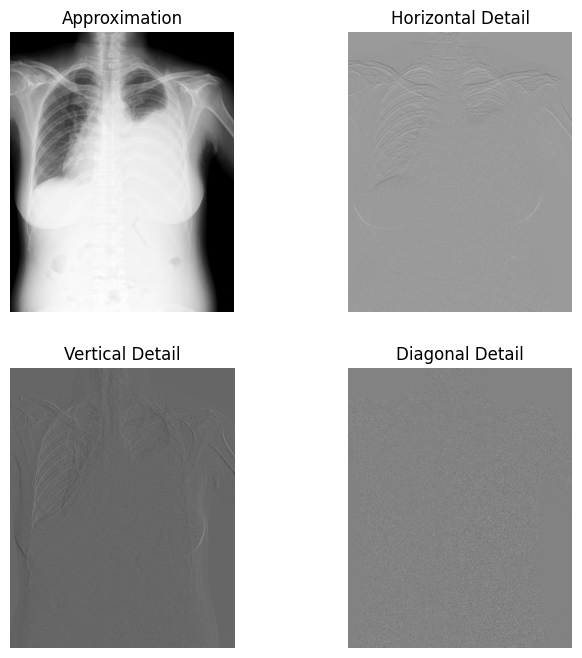

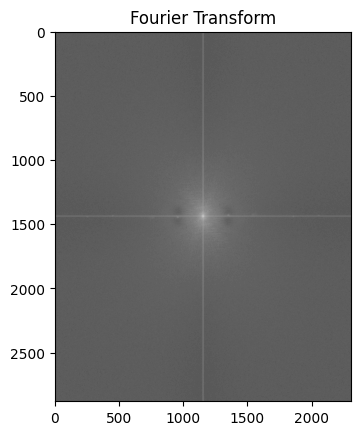

Wavelet Features: (6635520,)
Fourier Features: (6635520,)


In [393]:
wavelet_features = extract_wavelet_features(pixel_array, visualize=True)
fourier_features = extract_fourier_features(pixel_array, visualize=True)

print(f"Wavelet Features: {wavelet_features.shape}")
print(f"Fourier Features: {fourier_features.shape}")

## Features Selection

In [394]:
print(df_merged.shape)
df_merged.head()

(67914, 34)


,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,Transfer Syntax UID,SOP Class UID,...,Pixel Spacing,Bits Stored,Window Center,Window Width,Photometric_Interpretation_class,Transfer_Syntax_UID_class,SOP_Class_UID,Version_class,sex_class,age_class
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN,1.2.840.10008.1.2.4.90,1.2.840.10008.5.1.4.1.1.1,...,"[0.14300, 0.14300]",14,8191.0,16383.0,2,1,1,1,1,0
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN,1.2.840.10008.1.2,1.2.840.10008.5.1.4.1.1.1.1,...,"[0.125, 0.125]",12,2048.0,4096.0,2,2,2,0,0,0
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0,1.2.840.10008.1.2.4.90,1.2.840.10008.5.1.4.1.1.1,...,NaN,12,NaN,NaN,1,1,1,2,2,1
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0,1.2.840.10008.1.2.4.90,1.2.840.10008.5.1.4.1.1.1,...,"[0.15, 0.15]",12,2047.0,4095.0,1,1,1,2,2,0
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN,1.2.840.10008.1.2,1.2.840.10008.5.1.4.1.1.1,...,"[0.140, 0.140]",14,8375.0,8948.0,2,2,1,2,2,2


In [395]:
df_pixel_features = pd.read_csv('/Volumes/ALEXIS/ai_project_cranfield/dicom_pixels_features.csv')
df_pixel_features = df_pixel_features.rename(columns={"filename": "image_id"})
df_pixel_features['image_id'] = df_pixel_features['image_id'].str.replace('.dicom', '')
print(df_pixel_features.shape)
df_pixel_features.head()

(15000, 40)


,intensity_mean,intensity_std,intensity_median,glcm_contrast,glcm_correlation,glcm_energy,glcm_homogeneity,mean_gabor_real,std_gabor_real,mean_gabor_imag,...,haralick_9,haralick_10,haralick_11,haralick_12,sobel_edges_count,canny_edges_count,skewness,kurtosis,entropy,image_id
0,162.508754,53.610391,170.0,50.945162,0.991132,0.017460,0.176312,13.336609,27.888411,8.551008,...,0.015018,0.046868,-0.962266,0.939101,6611401,123449,-0.744572,0.210735,7.563331,005d70155f949c7785671800f2c8e1ca
1,125.648836,67.795674,144.0,7.800591,0.999151,0.116380,0.682880,7.823448,7.411495,1.016623,...,0.020257,0.036356,-0.966909,0.928575,6556797,84878,-0.669602,-0.808662,6.917080,0061cf6d35e253b6e7f03940592cc35e
2,107.468138,74.136839,115.0,80.262698,0.992697,0.063658,0.197132,25.949493,65.264177,3.803589,...,0.030123,0.026028,-0.975495,0.928329,8505142,23409,-0.128583,-1.317420,7.448992,006501b11e04aec2d403177b9ae0f34c
3,115.759135,63.175611,140.0,88.948071,0.988853,0.025961,0.251142,7.008416,5.248002,26.063167,...,0.039730,0.026295,-0.975028,0.925514,7626872,453359,-0.453477,-1.299697,7.459437,00675cd546313f912cadd4ad54415d69
4,132.849532,66.681063,143.0,7.035192,0.999209,0.050140,0.519648,8.137124,5.306767,0.117948,...,0.066030,0.022631,-0.978496,0.927692,7163833,7488,-0.511102,-0.841245,7.485881,006e2726c6aa72f042a08b1406c39d52


In [396]:
df_merged = df_merged.drop(
    columns=[
        "Pixel Representation",
        "Bits Allocated",
        "Rescale Intercept",
        "Rescale Slope",
        "Lossy Image Compression",
        "Lossy Image Compression Ratio",
        "Samples per Pixel"
    ]
)

In [397]:
df_merged.shape

(67914, 27)

In [398]:
for i in enumerate(df_merged.columns):
    print(i)

(0, 'image_id')
(1, 'class_name')
(2, 'class_id')
(3, 'rad_id')
(4, 'x_min')
(5, 'y_min')
(6, 'x_max')
(7, 'y_max')
(8, 'Transfer Syntax UID')
(9, 'SOP Class UID')
(10, 'Version')
(11, 'Photometric Interpretation')
(12, 'High Bit')
(13, "Patient's Sex")
(14, "Patient's Age")
(15, 'Rows')
(16, 'Columns')
(17, 'Pixel Spacing')
(18, 'Bits Stored')
(19, 'Window Center')
(20, 'Window Width')
(21, 'Photometric_Interpretation_class')
(22, 'Transfer_Syntax_UID_class')
(23, 'SOP_Class_UID')
(24, 'Version_class')
(25, 'sex_class')
(26, 'age_class')


In [399]:
image_id = df_merged['image_id']
df_merged = df_merged.drop(
        columns=[
            "image_id",
            "class_name",
            "rad_id",
            "Transfer Syntax UID",
            "SOP Class UID",
            "Photometric Interpretation",
            "Pixel Spacing",
            "Version",
            "Patient's Sex",
            "Patient's Age",
            "x_min",
            "y_min",
            "x_max",
            "y_max",
        ]
    )

In [400]:
import warnings

warnings.filterwarnings("ignore")

df_merged.replace(np.nan, 0, inplace=True)

In [401]:
df_corr = df_merged.corr()['class_id'].abs().sort_values(ascending=False)
df_corr

class_id                            1.000000
Version_class                       0.578087
age_class                           0.230906
Photometric_Interpretation_class    0.219379
SOP_Class_UID                       0.211320
Rows                                0.083882
Window Width                        0.083114
Columns                             0.080271
sex_class                           0.046877
Window Center                       0.030276
Transfer_Syntax_UID_class           0.025600
High Bit                            0.009233
Bits Stored                         0.009233
Name: class_id, dtype: float64

In [402]:
features = df_corr[df_corr > 0.2].index.to_list()[1:]
features            

['Version_class',
 'age_class',
 'Photometric_Interpretation_class',
 'SOP_Class_UID']

In [403]:
y = df_merged["class_id"]
X = df_merged.drop(columns=["class_id"])

In [426]:
X["image_id"] = image_id
# Keep only one row per image
X = X.drop_duplicates(subset="image_id")

In [427]:
print(X.shape)
X.head()

(15000, 13)


,High Bit,Rows,Columns,Bits Stored,Window Center,Window Width,Photometric_Interpretation_class,Transfer_Syntax_UID_class,SOP_Class_UID,Version_class,sex_class,age_class,image_id
0,13,2580,2332,14,8191.0,16383.0,2,1,1,1,1,0,50a418190bc3fb1ef1633bf9678929b3
1,11,3159,2954,12,2048.0,4096.0,2,2,2,0,0,0,21a10246a5ec7af151081d0cd6d65dc9
2,11,2336,2080,12,0.0,0.0,1,1,1,2,2,1,9a5094b2563a1ef3ff50dc5c7ff71345
3,11,2880,2304,12,2047.0,4095.0,1,1,1,2,2,0,051132a778e61a86eb147c7c6f564dfe
4,13,3072,2540,14,8375.0,8948.0,2,2,1,2,2,2,063319de25ce7edb9b1c6b8881290140


In [428]:
X = X.drop(columns=["image_id"])

In [404]:
is_null = df_merged.isnull().sum()
is_null[is_null > 0]

Series([], dtype: int64)

In [405]:
from sklearn.preprocessing import StandardScaler

# Assuming X is your dataset
scaler = StandardScaler()
X_standardized = scaler.fit_transform(
    X
)  # Standardize the dataset using the scaler object

In [406]:
y.shape

(67914,)

In [407]:
y

0        14
1        14
2         3
3         0
4        14
         ..
67909    14
67910    14
67911    14
67912     3
67913    14
Name: class_id, Length: 67914, dtype: int64

In [408]:
y_binary = y.apply(lambda x: 0 if x == 14 else 1)
y_binary

0        0
1        0
2        1
3        1
4        0
        ..
67909    0
67910    0
67911    0
67912    1
67913    0
Name: class_id, Length: 67914, dtype: int64

In [409]:
X_standardized.shape

(67914, 12)

In [410]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)  
X_reduced = pca.fit_transform(X_standardized, y)

print("Cumulative Variances (Percentage):")
print(np.cumsum(pca.explained_variance_ratio_ * 100))
components = len(pca.explained_variance_ratio_)
print(f"Number of components: {components}")

Cumulative Variances (Percentage):
[32.71528716 54.02349313 70.1421276  79.51764124 85.5941244  90.14992931
 93.73607537 96.41491645 98.22371923 99.71260137]
Number of components: 10


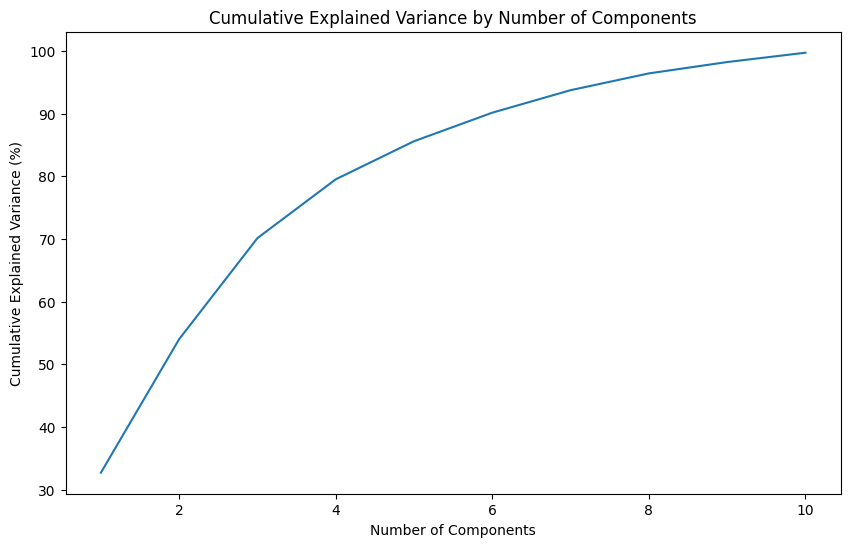

In [411]:
# Plot the explained variances
plt.figure(figsize=(10, 6))
sns.lineplot(
    x=np.arange(1, components + 1), y=np.cumsum(pca.explained_variance_ratio_ * 100)
)
plt.title("Cumulative Explained Variance by Number of Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance (%)")
plt.show()

In [412]:
pca_components = abs(pca.components_)
pca_components

array([[0.48423543, 0.08403027, 0.18531939, 0.48423543, 0.46259591,
        0.42493709, 0.20735683, 0.05534149, 0.05882172, 0.04746841,
        0.13040147, 0.16212313],
       [0.07644869, 0.45594036, 0.46832984, 0.07644869, 0.17314571,
        0.21119249, 0.26606882, 0.45418217, 0.27826153, 0.03520959,
        0.27309946, 0.23704108],
       [0.04083557, 0.2187384 , 0.17335893, 0.04083557, 0.08232319,
        0.14647978, 0.30435255, 0.16623348, 0.5444245 , 0.59596552,
        0.11873339, 0.3234147 ],
       [0.05419995, 0.35574317, 0.1561928 , 0.05419995, 0.05807945,
        0.11748611, 0.34020599, 0.30388134, 0.02976219, 0.23635917,
        0.53093158, 0.52846509],
       [0.11893812, 0.32248245, 0.37825292, 0.11893812, 0.09489316,
        0.16445077, 0.20914231, 0.23654533, 0.21750804, 0.15901359,
        0.6485478 , 0.30932984],
       [0.02699453, 0.20866726, 0.00926766, 0.02699453, 0.2060339 ,
        0.17727849, 0.64179322, 0.52151835, 0.170222  , 0.10378858,
        0.3774537 ,

In [413]:
print('Top most important features in each component:')
for row in range(pca_components.shape[0]):
    temp = np.argpartition(-(pca_components[row]), 4)
    indices = temp[np.argsort((-pca_components[row])[temp])][:4]
    print(f'Component {row}: {df_merged.columns[indices].to_list()}')

Top most important features in each component:
Component 0: ['Columns', 'class_id', 'Bits Stored', 'Window Center']
Component 1: ['Rows', 'High Bit', 'Photometric_Interpretation_class', 'Transfer_Syntax_UID_class']
Component 2: ['SOP_Class_UID', 'Transfer_Syntax_UID_class', 'sex_class', 'Window Width']
Component 3: ['Version_class', 'sex_class', 'High Bit', 'Window Width']
Component 4: ['Version_class', 'Rows', 'High Bit', 'sex_class']
Component 5: ['Window Width', 'Photometric_Interpretation_class', 'Version_class', 'High Bit']
Component 6: ['SOP_Class_UID', 'sex_class', 'Window Width', 'Photometric_Interpretation_class']
Component 7: ['Transfer_Syntax_UID_class', 'Photometric_Interpretation_class', 'SOP_Class_UID', 'High Bit']
Component 8: ['Rows', 'High Bit', 'Transfer_Syntax_UID_class', 'Window Width']
Component 9: ['Window Center', 'Columns', 'class_id', 'Rows']


In [414]:
features_name = X.columns

# Print top 10 features for each component
def print_top_features(components, features, n=10):
    for i, component in enumerate(components):
        print(f"Principal Component {i+1}")
        indices = np.argsort(component)[-n:]
        print([features[j] for j in indices])
        print("\n")

pca_top_features = []
for i, component in enumerate(pca.components_):
    indices = np.argsort(component)[-10:]
    best_features = [features_name[j] for j in indices]
    for feature in best_features:
        pca_top_features.append(feature)
print_top_features(pca.components_, features_name, n=10)

Principal Component 1
['Version_class', 'SOP_Class_UID', 'Rows', 'age_class', 'Columns', 'Photometric_Interpretation_class', 'Window Width', 'Window Center', 'High Bit', 'Bits Stored']


Principal Component 2
['Transfer_Syntax_UID_class', 'SOP_Class_UID', 'Photometric_Interpretation_class', 'age_class', 'Version_class', 'High Bit', 'Bits Stored', 'Window Center', 'Window Width', 'sex_class']


Principal Component 3
['Rows', 'Columns', 'Bits Stored', 'High Bit', 'Window Center', 'sex_class', 'Window Width', 'Transfer_Syntax_UID_class', 'Photometric_Interpretation_class', 'SOP_Class_UID']


Principal Component 4
['Window Width', 'Window Center', 'SOP_Class_UID', 'High Bit', 'Bits Stored', 'Version_class', 'Transfer_Syntax_UID_class', 'Photometric_Interpretation_class', 'age_class', 'sex_class']


Principal Component 5
['Rows', 'Photometric_Interpretation_class', 'Bits Stored', 'High Bit', 'Window Center', 'Version_class', 'Window Width', 'SOP_Class_UID', 'Transfer_Syntax_UID_class', 'age

In [415]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier


_sc = StandardScaler()
_pca = PCA(n_components=4)
_model = RandomForestClassifier(n_estimators=100, random_state=42)
pipeline_random_forest = Pipeline([("scaler", _sc), ("pca", _pca), ("model", _model)])

In [416]:
from sklearn.svm import SVC

_sc = StandardScaler()
_pca = PCA(n_components=4)
_model = SVC()
pipeline_SVMs = Pipeline([("scaler", _sc), ("pca", _pca), ("model", _model)])

In [417]:
from sklearn.feature_selection import SelectKBest, f_classif

# Apply SelectKBest
selector = SelectKBest(f_classif, k=15)  # Selects the top 10 features
X_new = selector.fit_transform(X, y)

# Get which features are selected
mask = selector.get_support()

# Print selected feature names
print("Selected Features:")
for bool, feature in zip(mask, features_name):
    if bool:
        print(feature)

best_features = []
for bool, feature in zip(mask, features_name):
    if bool:
        best_features.append(feature)

Selected Features:
High Bit
Rows
Columns
Bits Stored
Window Center
Window Width
Photometric_Interpretation_class
Transfer_Syntax_UID_class
SOP_Class_UID
Version_class
sex_class
age_class


## Splitting the Data

In [418]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y)

In [419]:
# scaler = StandardScaler()
# X_standardized_best_features = scaler.fit_transform(
#     X[best_features]
# )  # Standardize the dataset using the scaler object
# X_train, X_test_best, X_train, y_test_best = train_test_split(
#     X_standardized_best_features, y, test_size=0.15, stratify=y
# )

## Machine Learning Models

### Random Forest

In [420]:
y_train.value_counts()

class_id
14    27045
0      6088
3      4613
11     4116
13     3957
8      2193
7      2110
10     2104
9      1872
6      1060
5       850
2       816
4       473
1       237
12      192
Name: count, dtype: int64

In [421]:
def compute_mean_accury_per_class_id(y_true, y_pred):
    """
    Compute the mean accuracy per class_id.

    Parameters:
    - y_true: True class labels.
    - y_pred: Predicted class labels.

    Returns:
    - Mean accuracy per class_id.
    """
    # Combine the true and predicted labels
    df = pd.DataFrame({"y_true": y_true, "y_pred": y_pred})
    # Compute the accuracy per class_id
    accuracy_per_class_id = df.groupby("y_true").apply(
        lambda x: (x["y_true"] == x["y_pred"]).mean()
    )
    return accuracy_per_class_id

In [422]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Compute the mean accuracy per class_id
compute_mean_accury_per_class_id(y_test, y_pred)

y_true
0     0.286778
1     0.071429
2     0.159722
3     0.160934
4     0.084337
5     0.340000
6     0.176471
7     0.058981
8     0.382429
9     0.193353
10    0.115591
11    0.188705
12    0.235294
13    0.482808
14    0.983030
dtype: float64

### Test the Models 

In [444]:
import joblib

# train the model using the PCA components
pipeline = pipeline_random_forest.fit(X_train, y_train)

# save the model
joblib.dump(pipeline, 'random_forest.sav')

# load the model
pipeline_random_forest = joblib.load('random_forest.sav')

y_pred = pipeline_random_forest.predict(X)

# Compute the mean accuracy per class_id
compute_mean_accury_per_class_id(y_test, y_pred)

ValueError: array length 15000 does not match index length 10188

In [432]:
y_pred = pd.DataFrame(y_pred, columns=["class_id"])
y_pred["image_id"] = image_id

In [436]:
y = pd.DataFrame(y, columns=["class_id"])
y["image_id"] = image_id
y = y.drop_duplicates(subset="image_id")

In [437]:
y["class_id"].value_counts()

class_id
14    10606
0      1127
3       878
13      522
11      496
7       251
10      241
9       224
8       221
6       134
5       111
2        91
4        46
1        30
12       22
Name: count, dtype: int64

In [434]:
y_pred["class_id"].value_counts()

class_id
14    10829
0      1280
13     1027
3       725
11      283
8       171
10      153
9       125
7       117
5        99
6        80
2        59
4        22
12       18
1        12
Name: count, dtype: int64

In [438]:
y_combined = pd.merge(y, y_pred, on="image_id")

In [441]:
y_combined
# Compute the mean accuracy per class_id
compute_mean_accury_per_class_id(y_combined["class_id_x"], y_combined["class_id_y"])

y_true
0     0.088496
1     0.000000
2     0.000000
3     0.043341
4     0.000000
5     0.012397
6     0.010753
7     0.008081
8     0.017123
9     0.004264
10    0.016575
11    0.024704
12    0.022222
13    0.075716
14    0.729170
dtype: float64

In [442]:
y_combined

,class_id_x,image_id,class_id_y
0,14,50a418190bc3fb1ef1633bf9678929b3,14
1,14,21a10246a5ec7af151081d0cd6d65dc9,14
2,3,9a5094b2563a1ef3ff50dc5c7ff71345,3
3,3,9a5094b2563a1ef3ff50dc5c7ff71345,0
4,0,051132a778e61a86eb147c7c6f564dfe,0
...,...,...,...
14995,14,069d41d3e346a6333fe53c5e7ff83cd5,14
14996,14,cb23c75b43410b0ef6133d9979fd5c89,14
14997,0,c25a87784e4a9dd01911f626cbd1faeb,14
14998,6,1c1a57cb8b3893348ecfb6e704a1b87e,14


### Support Vector Machine

In [424]:
# train the model using the PCA components
pipeline_SVMs.fit(X_train, y_train)

y_pred = pipeline_SVMs.predict(X_test)

# Compute the mean accuracy per class_id
compute_mean_accury_per_class_id(y_test, y_pred)

y_true
0     0.679702
1     0.000000
2     0.000000
3     0.000000
4     0.000000
5     0.000000
6     0.000000
7     0.018767
8     0.000000
9     0.000000
10    0.000000
11    0.059229
12    0.000000
13    0.084527
14    0.963126
dtype: float64

In [425]:
from sklearn.svm import SVC

clf = SVC()
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Compute the mean accuracy per class_id
compute_mean_accury_per_class_id(y_test, y_pred)

y_true
0     0.077281
1     0.000000
2     0.000000
3     0.000000
4     0.000000
5     0.000000
6     0.000000
7     0.018767
8     0.000000
9     0.000000
10    0.000000
11    0.000000
12    0.000000
13    0.002865
14    0.988477
dtype: float64